In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

In [3]:
def show_image_plt(img_rgb):
    plt.imshow(img_rgb)
    plt.show()


def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def resize_to_square(vegi_bgr):
    img_size = 256
    height, width = vegi_bgr.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi_bgr, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        resized_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        resized_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        resized_img = r_img[0:img_size, 0:img_size]

    if(resized_img.shape[0] != img_size or resized_img.shape[1] != img_size):
        resized_img = r_img[0:img_size, 0:img_size]

    return resized_img

In [5]:
#path = "G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_9.jpg"
#vegi = cv2.imread(path.replace("\\","/")) # As BGR

def draw_contours(bgr_img, object_area=500):
    #gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    hue, saturation, value = cv2.split(hsv)
    
    blurred_sat = cv2.GaussianBlur(saturation, (7, 7), 0)
    #show_image_plt(blurred_sat)
    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # *****
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    #print("Edges")
    #show_image_plt(edges)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=4) 
    #print("DILATE")
    #show_image_plt(dilate)

    erode = cv2.erode(dilate, kernel, iterations=4)
    #print("ERODE")
    #show_image_plt(erode)
    #print("SHAPE: ", erode.shape)
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # ???
    
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)
            
            # Ellipse
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(bgr_img_copy, ellipse, (255, 255, 0), 2, cv2.LINE_AA)

            perimeter = cv2.arcLength(contour, True)
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            #print(f"Perimeter: {perimeter}  /// Circularity: {circularity}")
            #print("Draw Contour")
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True
    
    rgb = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    
    return rgb, more_than_one_box, box, rect

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)

    return h, w

def crop_minAreaRect(img_BGR, rect, h, w):
    pic = img_BGR.copy()
    # rotate img
    angle = rect[2]
    rows,cols = img_BGR.shape[0], img_BGR.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img_BGR,M,(cols,rows))
    #show_image_plt(img_rot)
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    box = np.intp(box)
    #print("BOX:", box)
    cv2.drawContours(img_rot, [box], 0, (255, 255, 255), 1) # white frame

    #pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    #pts[pts < 0] = 0

    #print("TRANSFORMED BOX: ", pts)
    w_rect = int(rect[1][0])
    h_rect = int(rect[1][1])

    # crop
    box = np.clip(box, a_min=0, a_max=None)

    img_crop_BGR = img_rot[box[1][1]:box[1][1]+h_rect, box[1][0]:box[1][0]+w_rect]

    #img_crop = img_rot[pts[1][1]:pts[0][1], 
    #                   pts[1][0]:pts[2][0]]#

    return img_crop_BGR

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    # BOX IS ROTATED
    return True

def get_color(rgb_segment):
    cropped_vegi_2D = rgb_segment.reshape((-1,3))
    # convert to np.float32
    cropped_vegi_2D = np.float32(cropped_vegi_2D)

    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    ret, label, center = cv2.kmeans(cropped_vegi_2D, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
   
    res = center[label.flatten()]
    res2 = res.reshape((rgb_segment.shape))
    
    #returns center in rgb format
    return center, ret, label

def mask_green(cropped_vegi_seg_rgb, lower_thresh=(30, 175, 25), higher_thresh=(100, 255, 255)):
    ## Convert to HSV
    cropped_vegi_seg_hsv = cv2.cvtColor(cropped_vegi_seg_rgb, cv2.COLOR_RGB2HSV)

    ## Mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(cropped_vegi_seg_hsv, lower_thresh, higher_thresh)
    
    ## Slice the green
    imask = mask>0
    green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    green_rgb[imask] = cropped_vegi_seg_rgb[imask]

    return green_rgb, imask

    #Image as BGR
def segment_img_2(cropped_vegi_bgr):
    #img must be BGR
    gray = cv2.cvtColor(cropped_vegi_bgr, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,kernel, iterations = 15)
    bg = cv2.dilate(closing, kernel, iterations = 1)
    dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
    ret, fg = cv2.threshold(dist_transform, 0.02*dist_transform.max(), 255, 0)

    return thresh

def color_from_segmented_binary(seg_bin, cropped_vegi_bgr):
    imask = seg_bin>0 #False / True array
    segment = np.zeros_like(cropped_vegi_bgr, np.uint8)
    segment[imask] = cropped_vegi_bgr[imask] #BGR

    segment_rgb = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB) #RGB

    return segment_rgb

def keep_object_remove_green(mask, cropped_vegi_seg_rgb):
    inverted_mask = np.invert(mask)
    inverted_green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    inverted_green_rgb[inverted_mask] = cropped_vegi_seg_rgb[inverted_mask]
    
    return inverted_green_rgb

def count_green_pixels(binary_green_mask):
    #only count True boolean. These are my green pixels
    return binary_green_mask.sum()
    


In [8]:
#folders = ["Zwiebel_Trieb", "Zwiebel", "Karotte_Trieb", "Kartoffel", "Karotte"]
#folders = ["Kartoffel", "Karotte"]
folders = ["Zwiebel_Trieb"]
#folders = ["Kartoffel_Trieb"]
paths = []
for fold in folders:
    lower = fold.lower()
    for i in range(15, 16): #87, 91
        paths.append(f"G:\Meine Ablage\KI_Projekt\Bilder\{fold}\{lower}_{i}.jpg")

In [7]:
paths = ["G:/Meine Ablage/KI_Projekt/Bilder/Karotte_Trieb/karotte_trieb_101.jpg",
               "G:/Meine Ablage/KI_Projekt/Bilder/Zwiebel_Trieb/zwiebel_trieb_53.jpg",
               "G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_45.jpg",
               "G:/Meine Ablage/KI_Projekt/Bilder/Zwiebel/zwiebel_106.jpg"]

++++++++++++++++++++NEW IMAGE 0 +++++++++++++++++++++++

SEGMENTED VEGI_256 AFTER PUTTING BINARY MASK ON IT


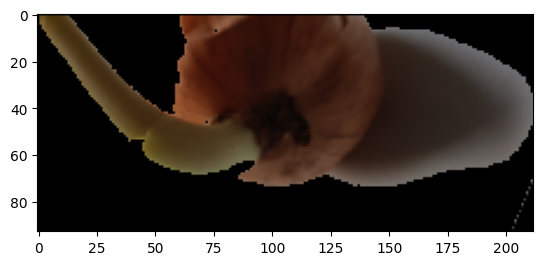

VEGI ONLY GREEN PIXXELS


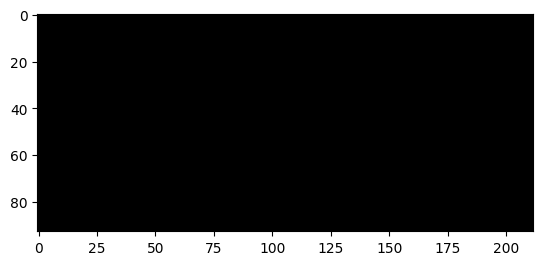

VEGI ONLY ONION TRIBE PIXXELS


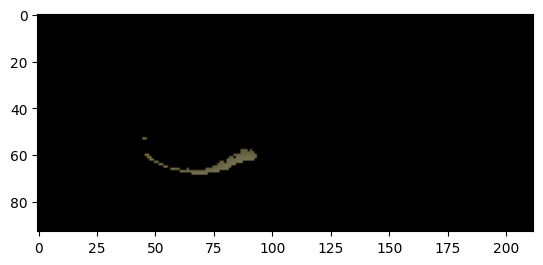

Center K-Means Algorith:  [[10  4  3]
 [81 59 43]]


In [9]:
#vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels" ,"Label"])
debug_img_list = list()
debug_list = list()        
center_points = np.array([0, 0, 0])
for i, path in enumerate(paths):
    print(f"++++++++++++++++++++NEW IMAGE {i} +++++++++++++++++++++++\n")
    #vegi_label = path.split("\\")[4]
    
    vegi_BGR = cv2.imread(path.replace("\\", "/")) # As BGR
    vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR
    
    try:
        vegi_with_box_rgb, more_than_one_box, box, rect = draw_contours(vegi_sq_BGR_original)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:
                #print("Increase Box Size by 250")
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect = draw_contours(vegi_sq_BGR_original, box_size)

        #print("VEGI_256 RGB WITH BOX")
        #show_image_plt(vegi_with_box_rgb)
        
        h, w = [int(l) for l in get_size_box(box)]
        #print(f"Height: {h}. width: {w}")

        if not is_box_rotated(box):
            #crop img directly
            #print("CROP DIRECTLY")
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = crop_minAreaRect(vegi_sq_BGR_original, rect, h, w) #BGR
    
        #print("CROPPED VEGI_256 RGB WITH BOX")
        #show_image_plt(cropped_vegi_BGR)

        cropped_segmented_binary = segment_img_2(cropped_vegi_BGR)
        #print("CROPPED VEGI_256 SEGMENTED BINARY MASK")
        #show_image_plt(cropped_segmented_binary)

        #print("Segment whole object")
        cropped_vegi_segmented_rgb = color_from_segmented_binary(cropped_segmented_binary, cropped_vegi_BGR) # center has rgb format
        print("SEGMENTED VEGI_256 AFTER PUTTING BINARY MASK ON IT")
        show_image_plt(cropped_vegi_segmented_rgb)

        #lower_thresh=(30, 105, 20), higher_thresh=(160, 255, 255) good default values.
        vegi_only_green_rgb, green_mask = mask_green(cropped_vegi_segmented_rgb, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        print("VEGI ONLY GREEN PIXXELS")
        show_image_plt(vegi_only_green_rgb)
        #####################################################
        #Mask for onion tribe
        vegi_only_onion_tribe_rgb, onion_tribe_mask = mask_green(cropped_vegi_segmented_rgb, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        print("VEGI ONLY ONION TRIBE PIXXELS")
        show_image_plt(vegi_only_onion_tribe_rgb)
        #####################################################
        # Keep object without
        cropped_vegi_green_removed_rgb = keep_object_remove_green(green_mask, cropped_vegi_segmented_rgb)

        amount_green_pixels = count_green_pixels(green_mask)
        #print("AMOUNT OF GREEN;: ", amount_green_pixels)
        #print("THIS IS Green ############################")
        #plt.imshow(vegi_only_green_rgb)
        #plt.show()

        center, ret, label = get_color(cropped_vegi_segmented_rgb) #Center = RGB
        R, G, B = np.max(center, axis=0)
        print("Center K-Means Algorith: ", center)
        #print("Center MAX: ", R, G, B)

        #print("Green removed")
        #plt.imshow(cropped_vegi_green_removed_rgb)
        #plt.show()

        #debug_img_list.append(vegi_with_box_rgb)
        #debug_img_list.append(cropped_vegi_BGR)
        #debug_img_list.append(vegi_only_green_rgb)
        #debug_img_list.append(cropped_vegi_green_removed_rgb)
        debug_img_list.append(cropped_vegi_segmented_rgb)
        debug_img_list.append(vegi_only_onion_tribe_rgb)
        #rgb_mean_color = calculate_object_color(cropped_vegi_green_removed_rgb)
        #print(f"Mean RGB COLOR: {rgb_mean_color}\n\n\n")

        center_points = np.vstack([center_points, center])

        #debug_list.append(amount_green_pixels)

        #vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels, vegi_label]
        
        #if i < 3:
           # print(vegis_df)
        #debug_color(vegi_only_green_rgb)
        #cv2.imwrite(f"G:\Meine Ablage\KI_Projekt\Bilder\BildermitBounding\only_green_3\img_{i}.jpg", cv2.cvtColor(vegi_only_green_rgb, cv2.COLOR_BGR2RGB))
        #cv2.imwrite(f"G:\Meine Ablage\KI_Projekt\Bilder\BildermitBounding\without_green_3\img_{i}.jpg", cv2.cvtColor(cropped_vegi_green_removed_rgb, cv2.COLOR_BGR2RGB))
    except Exception as e:
        print(f"############# Error: {e}")

In [25]:
def print_color_values(img, shape_row=(0, 50), shape_col=(0, 60)):
    for row in range(shape_row[0], shape_row[1]):
        for col in range(shape_col[0], shape_col[1]):
            print(f"Row {row}: Spalte {col} Pixel: {img[row, col]}")

In [16]:
crop_rgb = debug_img_list[0]
h, s, v = cv2.split(crop_rgb)
s[:] = 255


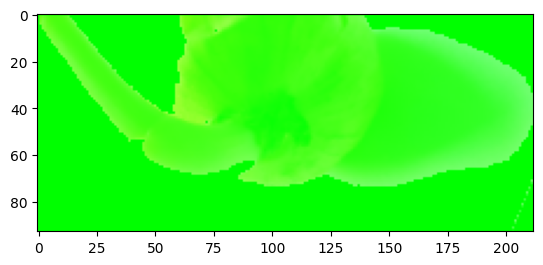

In [20]:
converted_back_hsv = cv2.merge([h, s, v])
show_image_plt(converted_back_hsv)

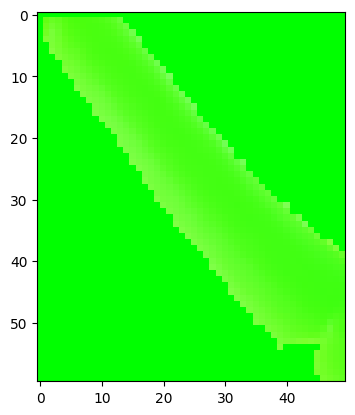

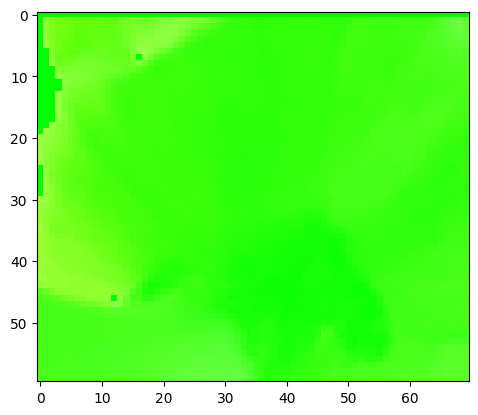

In [23]:
crop_conv_hsv_tribe = converted_back_hsv[0:60, 0:50]
crop_conv_hsv_onion = converted_back_hsv[0:60, 60:130]
show_image_plt(crop_conv_hsv_tribe)
show_image_plt(crop_conv_hsv_onion)

In [26]:
print_color_values(crop_conv_hsv_tribe, (0,60), (0,50))

Row 0: Spalte 0 Pixel: [  0 255   0]
Row 0: Spalte 1 Pixel: [  0 255   0]
Row 0: Spalte 2 Pixel: [  0 255   0]
Row 0: Spalte 3 Pixel: [  0 255   0]
Row 0: Spalte 4 Pixel: [  0 255   0]
Row 0: Spalte 5 Pixel: [  0 255   0]
Row 0: Spalte 6 Pixel: [  0 255   0]
Row 0: Spalte 7 Pixel: [  0 255   0]
Row 0: Spalte 8 Pixel: [  0 255   0]
Row 0: Spalte 9 Pixel: [  0 255   0]
Row 0: Spalte 10 Pixel: [  0 255   0]
Row 0: Spalte 11 Pixel: [  0 255   0]
Row 0: Spalte 12 Pixel: [  0 255   0]
Row 0: Spalte 13 Pixel: [  0 255   0]
Row 0: Spalte 14 Pixel: [  0 255   0]
Row 0: Spalte 15 Pixel: [  0 255   0]
Row 0: Spalte 16 Pixel: [  0 255   0]
Row 0: Spalte 17 Pixel: [  0 255   0]
Row 0: Spalte 18 Pixel: [  0 255   0]
Row 0: Spalte 19 Pixel: [  0 255   0]
Row 0: Spalte 20 Pixel: [  0 255   0]
Row 0: Spalte 21 Pixel: [  0 255   0]
Row 0: Spalte 22 Pixel: [  0 255   0]
Row 0: Spalte 23 Pixel: [  0 255   0]
Row 0: Spalte 24 Pixel: [  0 255   0]
Row 0: Spalte 25 Pixel: [  0 255   0]
Row 0: Spalte 26 Pixel

In [28]:
print_color_values(crop_conv_hsv_onion, (0,60), (0,60))

Row 0: Spalte 0 Pixel: [  0 255   0]
Row 0: Spalte 1 Pixel: [  0 255   0]
Row 0: Spalte 2 Pixel: [  0 255   0]
Row 0: Spalte 3 Pixel: [  0 255   0]
Row 0: Spalte 4 Pixel: [  0 255   0]
Row 0: Spalte 5 Pixel: [  0 255   0]
Row 0: Spalte 6 Pixel: [  0 255   0]
Row 0: Spalte 7 Pixel: [  0 255   0]
Row 0: Spalte 8 Pixel: [  0 255   0]
Row 0: Spalte 9 Pixel: [  0 255   0]
Row 0: Spalte 10 Pixel: [  0 255   0]
Row 0: Spalte 11 Pixel: [  0 255   0]
Row 0: Spalte 12 Pixel: [  0 255   0]
Row 0: Spalte 13 Pixel: [  0 255   0]
Row 0: Spalte 14 Pixel: [  0 255   0]
Row 0: Spalte 15 Pixel: [  0 255   0]
Row 0: Spalte 16 Pixel: [  0 255   0]
Row 0: Spalte 17 Pixel: [  0 255   0]
Row 0: Spalte 18 Pixel: [  0 255   0]
Row 0: Spalte 19 Pixel: [  0 255   0]
Row 0: Spalte 20 Pixel: [  0 255   0]
Row 0: Spalte 21 Pixel: [  0 255   0]
Row 0: Spalte 22 Pixel: [  0 255   0]
Row 0: Spalte 23 Pixel: [  0 255   0]
Row 0: Spalte 24 Pixel: [  0 255   0]
Row 0: Spalte 25 Pixel: [  0 255   0]
Row 0: Spalte 26 Pixel

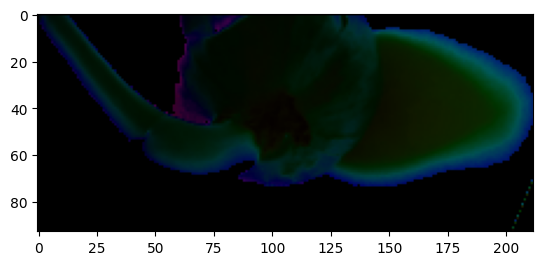

In [22]:
converted_back_rgb = cv2.cvtColor(converted_back_hsv, cv2.COLOR_HSV2RGB)
show_image_plt(converted_back_rgb)

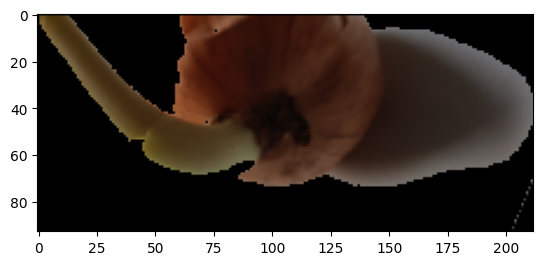

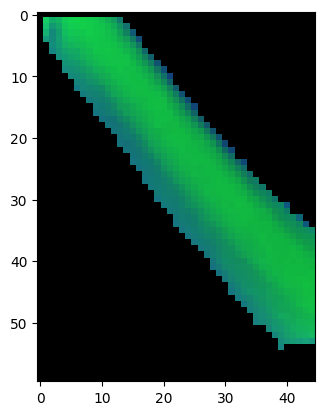

In [11]:
show_image_plt(debug_img_list[0])
hsv = cv2.cvtColor(debug_img_list[0], cv2.COLOR_RGB2HSV)
crop_hsv = hsv[:60, 0:45]
show_image_plt(crop_hsv)

In [12]:
center, ret, label = get_color(crop_hsv)
center

array([[  0,   0,   0],
       [ 17, 157,  87]], dtype=uint8)

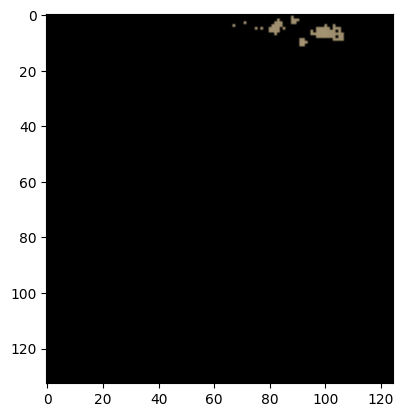

array([[ 20,  77, 160],
       [  0,   0,   0]], dtype=uint8)

In [55]:
show_image_plt(debug_img_list[1])
hsv = cv2.cvtColor(debug_img_list[1], cv2.COLOR_RGB2HSV)
center, ret, label = get_color(hsv)
center

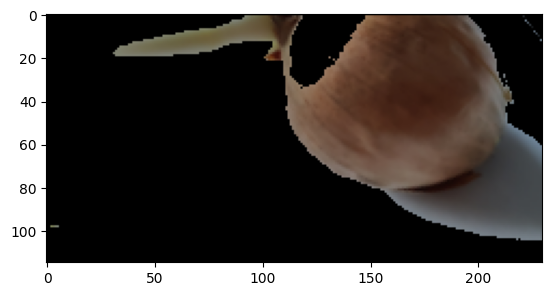

In [23]:
show_image_plt(debug_img_list[7])

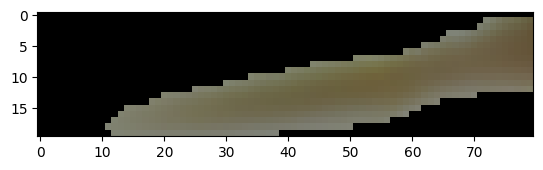

array([[115, 110,  85],
       [  0,   0,   0]], dtype=uint8)

In [38]:
cut_tribe = debug_img_list[7][0:20, 20:100]
cut_tribe.shape
show_image_plt(cut_tribe)
center, ret, label = get_color(cut_tribe)
center

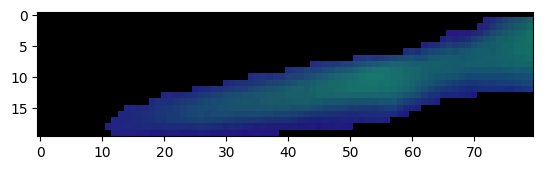

array([[  0,   0,   0],
       [ 26,  68, 115]], dtype=uint8)

In [39]:
cut_tribe_hsv = cv2.cvtColor(debug_img_list[7][0:20, 20:100], cv2.COLOR_RGB2HSV)
cut_tribe_hsv.shape
show_image_plt(cut_tribe_hsv)
center, ret, label = get_color(cut_tribe_hsv)
center

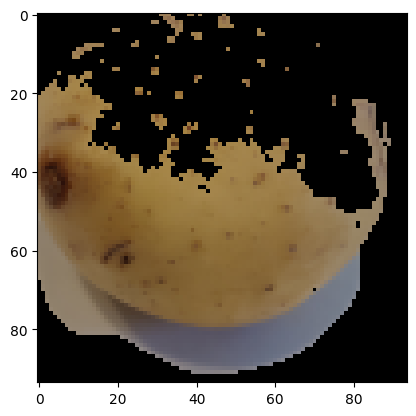

In [44]:
len(debug_img_list)
show_image_plt(debug_img_list[87])

In [25]:
#Get Pixel RGB Values from onion tribe
print_color_values(debug_img_list[7], (0,21), (20, 100))

Row 0: Spalte 20 Pixel: [0 0 0]
Row 0: Spalte 21 Pixel: [0 0 0]
Row 0: Spalte 22 Pixel: [0 0 0]
Row 0: Spalte 23 Pixel: [0 0 0]
Row 0: Spalte 24 Pixel: [0 0 0]
Row 0: Spalte 25 Pixel: [0 0 0]
Row 0: Spalte 26 Pixel: [0 0 0]
Row 0: Spalte 27 Pixel: [0 0 0]
Row 0: Spalte 28 Pixel: [0 0 0]
Row 0: Spalte 29 Pixel: [0 0 0]
Row 0: Spalte 30 Pixel: [0 0 0]
Row 0: Spalte 31 Pixel: [0 0 0]
Row 0: Spalte 32 Pixel: [0 0 0]
Row 0: Spalte 33 Pixel: [0 0 0]
Row 0: Spalte 34 Pixel: [0 0 0]
Row 0: Spalte 35 Pixel: [0 0 0]
Row 0: Spalte 36 Pixel: [0 0 0]
Row 0: Spalte 37 Pixel: [0 0 0]
Row 0: Spalte 38 Pixel: [0 0 0]
Row 0: Spalte 39 Pixel: [0 0 0]
Row 0: Spalte 40 Pixel: [0 0 0]
Row 0: Spalte 41 Pixel: [0 0 0]
Row 0: Spalte 42 Pixel: [0 0 0]
Row 0: Spalte 43 Pixel: [0 0 0]
Row 0: Spalte 44 Pixel: [0 0 0]
Row 0: Spalte 45 Pixel: [0 0 0]
Row 0: Spalte 46 Pixel: [0 0 0]
Row 0: Spalte 47 Pixel: [0 0 0]
Row 0: Spalte 48 Pixel: [0 0 0]
Row 0: Spalte 49 Pixel: [0 0 0]
Row 0: Spalte 50 Pixel: [0 0 0]
Row 0: S

In [ ]:
fig, axarr = plt.subplots(4, 2, figsize=(20, 20)) #2 row, 2 cols
fig.tight_layout(h_pad=4)

axarr[0][0].imshow(debug_img_list[0])
axarr[0][0].set_title("Original with Box")
axarr[0][1].imshow(debug_img_list[2])
axarr[0][1].set_title("Only Green")

axarr[1][0].imshow(debug_img_list[4])
axarr[1][0].set_title("Original with Box")
axarr[1][1].imshow(debug_img_list[6])
axarr[1][1].set_title("Only Green")

axarr[2][0].imshow(debug_img_list[8])
axarr[2][0].set_title("Original with Box")
axarr[2][1].imshow(debug_img_list[10])
axarr[2][1].set_title("Only Green")

axarr[3][0].imshow(debug_img_list[12])
axarr[3][0].set_title("Original with Box")
axarr[3][1].imshow(debug_img_list[14])
axarr[3][1].set_title("Only Green")

#plt.subplots_adjust(top = 0.85)

In [ ]:
show_image_plt(debug_img_list[5])
show_image_plt(debug_img_list[6])
show_image_plt(debug_img_list[7])

In [ ]:
hsv = cv2.cvtColor(debug_img_list[5], cv2.COLOR_BGR2HSV)
show_image_plt(hsv)
print_color_values(hsv, shape_row=(20,115), shape_col=(0, 60))